In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['legend.frameon'] = True

In [2]:
import pandas as pd
import numpy as np

# Реальные средние температуры (примерные данные) для городов по сезонам
seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=10):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('data/temperature_data.csv', index=False)
data.shape

(54750, 4)

# Концептуальная аналитическая часть

### Вычислить скользящее среднее температуры с окном в 30 дней для сглаживания краткосрочных колебаний.

In [3]:
WINDOW = 30
CITIES = data["city"].unique()

In [4]:
def running_mean(city_data):
    x = city_data["temperature"]
    r_mean = np.convolve(x, np.ones(WINDOW) / WINDOW, mode='valid')
    city_data = city_data.iloc[WINDOW-1:].copy()
    city_data[f"mean_{WINDOW}"] = r_mean
    return city_data

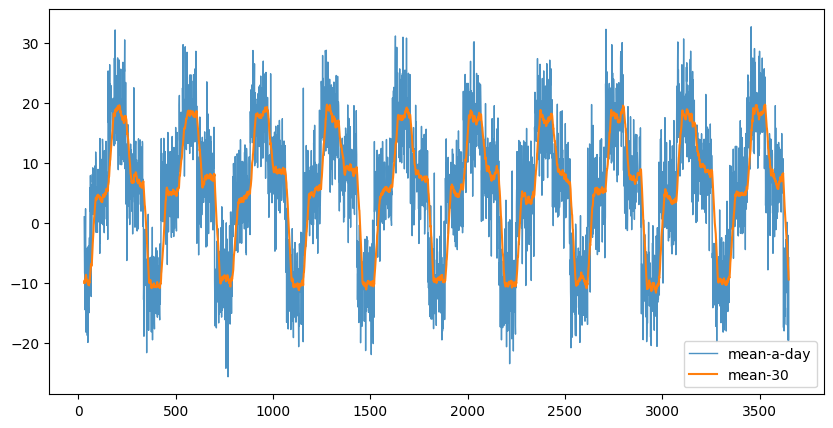

In [5]:
msk_rm = running_mean(data[data["city"] == "Moscow"])

x = msk_rm["temperature"]
x_rm = msk_rm["mean_30"]
days = range(WINDOW, len(x_rm) + WINDOW)

plt.plot(days, x, linewidth=1.0, alpha=0.8, label="mean-a-day")
plt.plot(days, x_rm, linewidth=1.5, label="mean-30")
plt.legend()
plt.show()

In [6]:
running_mean_data = pd.concat(
    [running_mean(data[data["city"] == city]) for city in CITIES],
    axis=0
)

running_mean_data

,city,timestamp,temperature,season,mean_30
29,New York,2010-01-30,-7.741312,winter,1.042522
30,New York,2010-01-31,-9.508984,winter,0.474930
31,New York,2010-02-01,-5.078890,winter,0.186294
32,New York,2010-02-02,-0.904086,winter,-0.176912
33,New York,2010-02-03,-0.755183,winter,-0.284811
...,...,...,...,...,...
54745,Mexico City,2019-12-25,15.246034,winter,12.540893
54746,Mexico City,2019-12-26,16.656990,winter,12.438167
54747,Mexico City,2019-12-27,8.675361,winter,12.277384
54748,Mexico City,2019-12-28,10.931897,winter,12.364025


### Рассчитать среднюю температуру и стандартное отклонение для каждого сезона в каждом городе.

In [7]:
mean_std_data = running_mean_data.groupby(["city", "season"])["mean_30"].agg(["mean", "std"])

mean_std_data["high_q"] = mean_std_data["mean"] + 2 * mean_std_data["std"]
mean_std_data["low_q"] = mean_std_data["mean"] - 2 * mean_std_data["std"]

mean_std_data

mean       std     high_q      low_q
city           season                                           
Beijing        autumn  17.872308  3.343978  24.560264  11.184353
               spring  10.763190  4.461187  19.685565   1.840816
               summer  25.022711  3.981269  32.985249  17.060173
               winter   0.912686  5.300726  11.514138  -9.688766
Berlin         autumn  12.545986  2.763757  18.073499   7.018473
               spring   8.311210  3.107662  14.526534   2.095887
               summer  18.214306  2.927559  24.069424  12.359188
               winter   1.890740  3.113025   8.116791  -4.335310
Cairo          autumn  26.703208  2.895804  32.494815  20.911600
               spring  23.605170  2.984205  29.573579  17.636761
               summer  33.602243  2.792523  39.187289  28.017197
               winter  16.631412  2.848968  22.329349  10.933476
Dubai          autumn  31.331128  2.841363  37.013855  25.648402
               spring  28.411723  3.137821  34.687364  22.136082
               summer  38.645728  2.949618  44.544963  32.746492
               winter  21.580167  2.934604  27.449375  15.710959
London         autumn  12.600988  1.789736  16.180461   9.021515
               spring   9.986268  1.779878  13.546024   6.426511
               summer  16.694196  2.058622  20.811441  12.576952
               winter   6.488115  2.018871  10.525857   2.450373
Los Angeles    autumn  21.088921  1.559856  24.208633  17.969208
               spring  17.289274  1.268954  19.827182  14.751366
               summer  23.974041  2.063666  28.101374  19.846708
               winter  15.945931  1.815421  19.576773  12.315088
Mexico City    autumn  15.716388  1.536406  18.789200  12.643576
               spring  16.888975  2.028976  20.946928  12.831022
               summer  19.905640  1.157383  22.220406  17.590873
               winter  12.631676  1.198910  15.029496  10.233856
Moscow         autumn   9.508725  2.911608  15.331941   3.685509
               spring   2.526131  4.168098  10.862327  -5.810065
               summer  15.960131  3.586021  23.132173   8.788089
               winter  -6.901030  5.204703   3.508376 -17.310437
Mumbai         autumn  30.783673  1.617118  34.017910  27.549437
               spring  29.159492  1.691605  32.542703  25.776282
               summer  34.025594  1.624515  37.274624  30.776564
               winter  25.745124  1.706275  29.157675  22.332574
New York       autumn  16.479316  3.099436  22.678188  10.280443
               spring   8.371851  2.991278  14.354408   2.389294
               summer  22.743745  4.271341  31.286427  14.201062
               winter   2.429531  4.268450  10.966431  -6.107369
Paris          autumn  14.379544  2.158119  18.695782  10.063306
               spring  10.519780  2.484865  15.489511   5.550050
               summer  18.972048  2.690958  24.353964  13.590131
               winter   5.581277  2.892284  11.365845  -0.203291
Rio de Janeiro autumn  25.643089  1.849580  29.342250  21.943928
               spring  24.002632  1.808449  27.619529  20.385734
               summer  29.381204  1.726848  32.834900  25.927508
               winter  20.697594  1.929386  24.556367  16.838821
Singapore      autumn  27.047328  0.916929  28.881187  25.213470
               spring  27.840949  0.943955  29.728859  25.953040
               summer  27.831633  0.852831  29.537295  26.125971
               winter  27.031354  0.928756  28.888867  25.173842
Sydney         autumn  21.301211  1.791622  24.884454  17.717967
               spring  16.998075  2.097734  21.193543  12.802608
               summer  23.974973  2.207254  28.389481  19.560465
               winter  13.475783  2.672367  18.820517   8.131048
Tokyo          autumn  19.315987  2.621736  24.559458  14.072516
               spring  13.568836  2.512465  18.593765   8.543906
               summer  25.007727  3.615522  32.238770  17.776684
               winter   8.029728  3.615120  15.259968   0.79948

### Выявить аномалии, где температура выходит за пределы $ \text{среднее} \pm 2\sigma $.

Наиболее оптимально -- через мультииндекс, если посортируем

In [8]:
data = data.set_index(["city", "season"]).sort_index()
data = data.sort_index()
data

timestamp  temperature
city    season                        
Beijing autumn 2010-09-01    13.844259
        autumn 2010-09-02    13.945510
        autumn 2010-09-03    17.425896
        autumn 2010-09-04    12.089274
        autumn 2010-09-05    19.271750
...                   ...          ...
Tokyo   winter 2019-12-25    -0.715699
        winter 2019-12-26     5.877638
        winter 2019-12-27    -0.518417
        winter 2019-12-28     7.611069
        winter 2019-12-29     3.524597

[54750 rows x 2 columns]

In [9]:
def find_anomal(data, temp_col="temperature"):
    for city in CITIES:
        for season in ["winter", "summer", "autumn", "spring"]:
            loc = (city, season)
            high_q, low_q = mean_std_data.loc[loc, ["high_q", "low_q"]]
            data.loc[[loc], "is_anomal"] = (~data.loc[[loc], temp_col].between(low_q, high_q)).astype(int)
    return data

In [10]:
labeled_data = find_anomal(data).reset_index()
labeled_data

,city,season,timestamp,temperature,is_anomal
0,Beijing,autumn,2010-09-01,13.844259,0.0
1,Beijing,autumn,2010-09-02,13.945510,0.0
2,Beijing,autumn,2010-09-03,17.425896,0.0
3,Beijing,autumn,2010-09-04,12.089274,0.0
4,Beijing,autumn,2010-09-05,19.271750,0.0
...,...,...,...,...,...
54745,Tokyo,winter,2019-12-25,-0.715699,1.0
54746,Tokyo,winter,2019-12-26,5.877638,0.0
54747,Tokyo,winter,2019-12-27,-0.518417,1.0
54748,Tokyo,winter,2019-12-28,7.611069,0.0


# Сравнение с параллелизацией

Возьмем данные пожирнее. Таски будем делить по городам, выполнять параллельно, а потом коллектить

In [11]:
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()), 30)
data.shape

(164250, 4)

**Замеряем как есть**

In [12]:
%%timeit
running_mean_data = pd.concat(
    [running_mean(data[data["city"] == city]) for city in CITIES],
    axis=0
)

mean_std_data = running_mean_data.groupby(["city", "season"])["mean_30"].agg(["mean", "std"])
mean_std_data["high_q"] = mean_std_data["mean"] + 2 * mean_std_data["std"]
mean_std_data["low_q"] = mean_std_data["mean"] - 2 * mean_std_data["std"]

data_indexed = data.set_index(["city", "season"]).sort_index()
find_anomal(data_indexed).reset_index()

764 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Накидываем асинхронность**

In [13]:
async def process_data(data, city):
    city_data = data[data["city"] == city].copy()
    # Считаем среднее
    city_r_mean = running_mean(city_data)
    # Считаем отклонения
    mean_std_data = city_r_mean.groupby("season")["mean_30"].agg(["mean", "std"])
    mean_std_data["high_q"] = mean_std_data["mean"] + 2 * mean_std_data["std"]
    mean_std_data["low_q"] = mean_std_data["mean"] - 2 * mean_std_data["std"]
    # Размечаем
    for season in ["winter", "summer", "autumn", "spring"]:
        season_mask = (data["season"] == season)
        high_q, low_q = mean_std_data.loc[season, ["high_q", "low_q"]]
        city_data.loc[season_mask, "is_anomal"] = (~city_data.loc[season_mask, "temperature"].between(low_q, high_q)).astype(int)
    return city_data

In [14]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

async def process_all(data):
    tasks = [process_data(data, city) for city in CITIES]
    cities_frames = await asyncio.gather(*tasks)
    return pd.concat(cities_frames, axis=0)

In [15]:
%%timeit
# await process_all(data)
asyncio.run(process_all(data))

925 ms ± 57.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ради интереса запустим потоки

In [16]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_data(data, city):
    city_data = data[data["city"] == city].copy()
    # Считаем среднее
    city_r_mean = running_mean(city_data)
    # Считаем отклонения
    mean_std_data = city_r_mean.groupby("season")["mean_30"].agg(["mean", "std"])
    mean_std_data["high_q"] = mean_std_data["mean"] + 2 * mean_std_data["std"]
    mean_std_data["low_q"] = mean_std_data["mean"] - 2 * mean_std_data["std"]
    # Размечаем
    for season in ["winter", "summer", "autumn", "spring"]:
        season_mask = (data["season"] == season)
        high_q, low_q = mean_std_data.loc[season, ["high_q", "low_q"]]
        city_data.loc[season_mask, "is_anomal"] = (~city_data.loc[season_mask, "temperature"].between(low_q, high_q)).astype(int)
    return city_data

In [17]:
%%timeit
with ThreadPoolExecutor(max_workers=8) as executor:
    city_futures = [executor.submit(process_data, data, city) for city in CITIES]
    done_futures = as_completed(city_futures)
    res = pd.concat([f.result() for f in done_futures], axis=0)

815 ms ± 71.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
with ThreadPoolExecutor(max_workers=15) as executor:
    city_futures = [executor.submit(process_data, data, city) for city in CITIES]
    done_futures = as_completed(city_futures)
    res = pd.concat([f.result() for f in done_futures], axis=0)

806 ms ± 49.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


В целом, я применял одну и ту же логику для чистого сравнения и там и здесь -- разница лишь в том, что параллельно мы обрабатываем каждый город отдельно. И асинхронка, и потоки проигрывают даже на данных большего размера (более того, первый подход по времени даже особо не меняется). Вывод -- идея так себе, лучше попробовать более рационально векторизировать вычисления, избегая двойного цикла по городам и сезонам.

# Взаимодействие с API

In [19]:
import os
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.environ.get("OWM_API_KEY")

Запрос состоит из двух частей. Первая -- запрос на координаты города, вторая -- получение температуры по переданным координатам

In [20]:
import requests

def get_temp(city):
    payload = {"q": city, "appid": API_KEY}
    response = requests.get("http://api.openweathermap.org/geo/1.0/direct", params=payload).json()[0]
    lat, lon = response["lat"], response["lon"]

    payload = {
        "lat": lat, "lon": lon,
        "appid": API_KEY, "units": "metric"
    }
    response = requests.get("https://api.openweathermap.org/data/2.5/weather", params=payload).json()
    return response["main"]["temp"]

In [21]:
from tqdm.notebook import tqdm

data_dict = {"city": [], "today_temp": []}
for city in tqdm(CITIES):
    data_dict["city"].append(city)
    data_dict["today_temp"].append(get_temp(city))
temps_df = pd.DataFrame(data_dict)
temps_df["season"] = "winter"
temps_df

  0%|          | 0/15 [00:00<?, ?it/s]

,city,today_temp,season
0,New York,-8.32,winter
1,London,6.24,winter
2,Paris,4.74,winter
3,Tokyo,3.71,winter
4,Moscow,-1.78,winter
5,Sydney,23.33,winter
6,Berlin,5.80,winter
7,Beijing,-5.08,winter
8,Rio de Janeiro,26.34,winter
9,Dubai,23.02,winter


Так как один сезон, можно просто использовать `apply`

In [22]:
def is_anomal(row):
    city, season = row["city"], row["season"]
    loc = (city, season)
    high_q, low_q = mean_std_data.loc[loc, ["high_q", "low_q"]]
    return 1 - int(low_q <= row["today_temp"] <= high_q)

temps_df["is_anomal"] = temps_df.apply(is_anomal, axis=1)
temps_df

,city,today_temp,season,is_anomal
0,New York,-8.32,winter,1
1,London,6.24,winter,0
2,Paris,4.74,winter,0
3,Tokyo,3.71,winter,0
4,Moscow,-1.78,winter,0
5,Sydney,23.33,winter,1
6,Berlin,5.80,winter,0
7,Beijing,-5.08,winter,0
8,Rio de Janeiro,26.34,winter,1
9,Dubai,23.02,winter,0


**Асинхронные запросы**

Разумеется, запросы лучше всего отсылать в асинхронном формате: в очереди пользователей вряд ли кто-то будет ждать своей очереди.

In [23]:
import aiohttp

async def get_temp(session, city):
    payload = {"q": city, "appid": API_KEY}
    async with session.get("http://api.openweathermap.org/geo/1.0/direct", params=payload) as response:
        response_data = await response.json()
        lat, lon = response_data[0]["lat"], response_data[0]["lon"]

    payload = {
        "lat": lat, "lon": lon,
        "appid": API_KEY, "units": "metric"
    }
    async with session.get("https://api.openweathermap.org/data/2.5/weather", params=payload) as response:
        weather_data = await response.json()
        return weather_data["main"]["temp"]
        

async def main():
    data_dict = {"city": [], "today_temp": []}
    async with aiohttp.ClientSession() as session:
        tasks = []
        for city in CITIES:
            tasks.append(get_temp(session, city))

        temps = await asyncio.gather(*tasks)

        for city, temp in zip(CITIES, temps):
            data_dict["city"].append(city)
            data_dict["today_temp"].append(temp)

    temps_df = pd.DataFrame(data_dict)
    temps_df["season"] = "winter"
    return temps_df

In [24]:
asyncio.run(main())

,city,today_temp,season
0,New York,-8.32,winter
1,London,6.24,winter
2,Paris,4.74,winter
3,Tokyo,3.71,winter
4,Moscow,-1.78,winter
5,Sydney,23.33,winter
6,Berlin,5.80,winter
7,Beijing,-5.08,winter
8,Rio de Janeiro,26.34,winter
9,Dubai,23.02,winter


In [39]:
city_data = labeled_data[labeled_data["city"] == "Moscow"].sort_values("timestamp")
city_data

,city,season,timestamp,temperature,is_anomal
28300,Moscow,winter,2010-01-01,-11.711814,0.0
28301,Moscow,winter,2010-01-02,-13.496193,0.0
28302,Moscow,winter,2010-01-03,-3.359846,0.0
28303,Moscow,winter,2010-01-04,-0.660145,0.0
28304,Moscow,winter,2010-01-05,-18.929753,1.0
...,...,...,...,...,...
29195,Moscow,winter,2019-12-25,-2.047741,0.0
29196,Moscow,winter,2019-12-26,-6.703423,0.0
29197,Moscow,winter,2019-12-27,-9.556238,0.0
29198,Moscow,winter,2019-12-28,-19.557133,1.0


In [54]:
def plot_temperature_series(data, title=None):
    plt.figure(figsize=(12, 5))
    plt.plot(data['timestamp'], data['temperature'], label='Температура', color='royalblue')

    window = 30
    running_mean = np.convolve(data['temperature'], np.ones(window) / window, mode='valid')
    plt.plot(data['timestamp'].values[window-1:], running_mean, label=f'Среднее ({window} дней)', color='lime')

    anomaly_data = data[data["is_anomal"] == 1]
    plt.scatter(anomaly_data["timestamp"], anomaly_data['temperature'], label='Аномалии', color='red')

    if title is not None:
    	plt.title(title)

    plt.xlabel('Дата')
    plt.ylabel('Температура')
    plt.xticks(rotation=45)
    plt.legend()

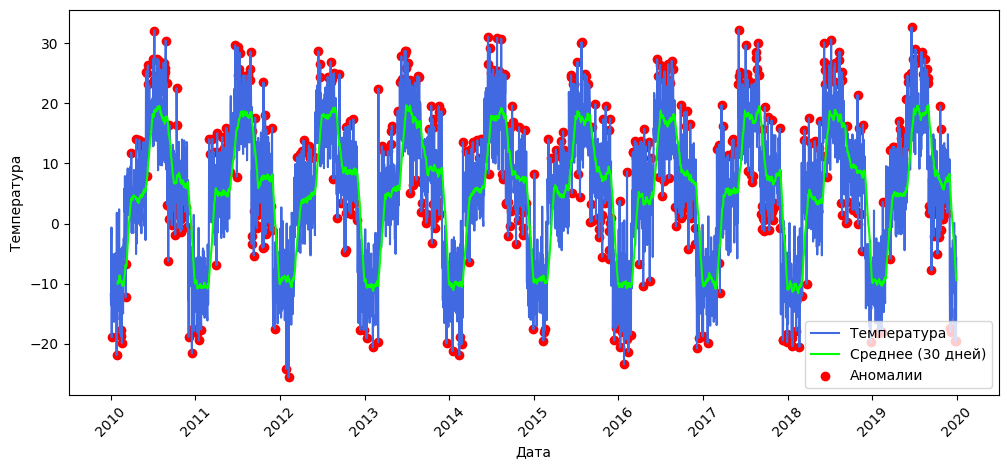

In [55]:
plot_temperature_series(city_data)

In [56]:
city_data.groupby("season")["temperature"].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
autumn,910.0,7.883131,4.857693,-7.811280,4.710161,8.092422,11.215097,24.801097
spring,920.0,4.868583,4.962421,-12.241276,1.492268,4.898966,7.952468,22.408634
summer,920.0,17.985561,5.034320,1.366728,14.613651,18.002624,21.365891,32.617726
winter,900.0,-9.821088,5.061623,-25.590697,-13.589344,-9.709600,-6.593584,8.633713


In [118]:
def plot_profiles(data, title=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    for i, season in enumerate(["winter", "spring", "autumn", "summer"]):
        ax = axes[i // 2][i % 2]
        ax.set_title(season)
        ax.set_ylim([-25, 35])
        if i % 2 == 1:
            ax.set_yticks([])
        
        season_data = city_data[city_data["season"] == season].copy()
        season_data["date"] = season_data['timestamp'].dt.strftime("%d/%m")
        mean_temps = season_data.groupby("date")["temperature"].mean()
        
        ax.plot(range(len(mean_temps)), mean_temps, color='blue')
        
        mean = season_data['temperature'].mean()
        std = season_data['temperature'].std()
        ax.annotate(f"mean: {mean:.2f}\nstd: {std:.2f}", xy=(0, 25))

    fig.supxlabel('№ дня сезона')
    fig.supylabel('Средняя погодоваря температура')
    plt.tight_layout()

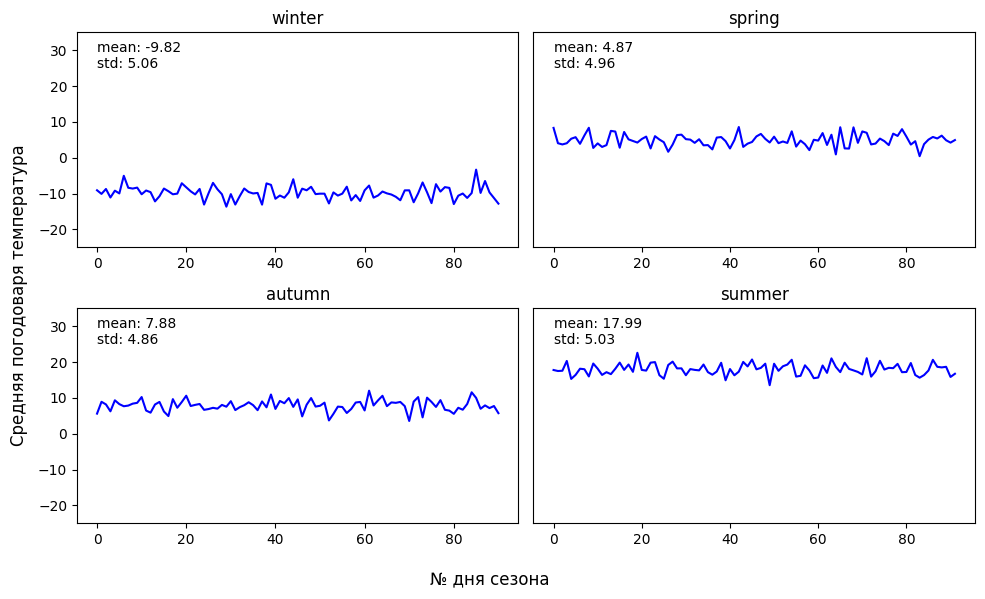

In [119]:
plot_profiles(city_data)

In [88]:
season_data

,city,season,timestamp,temperature,is_anomal,year,date
28300,Moscow,winter,2010-01-01,-11.711814,0.0,2010,01/01
28301,Moscow,winter,2010-01-02,-13.496193,0.0,2010,02/01
28302,Moscow,winter,2010-01-03,-3.359846,0.0,2010,03/01
28303,Moscow,winter,2010-01-04,-0.660145,0.0,2010,04/01
28304,Moscow,winter,2010-01-05,-18.929753,1.0,2010,05/01
...,...,...,...,...,...,...,...
29195,Moscow,winter,2019-12-25,-2.047741,0.0,2019,25/12
29196,Moscow,winter,2019-12-26,-6.703423,0.0,2019,26/12
29197,Moscow,winter,2019-12-27,-9.556238,0.0,2019,27/12
29198,Moscow,winter,2019-12-28,-19.557133,1.0,2019,28/12
